In [1]:
%load_ext autoreload
%autoreload

#### Prepare Dataset

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds

import deeply.datasets as dd
from deeply.datasets.util import split as split_dataset
from deeply.generators import DatasetGenerator

In [3]:
ds, info = dd.load("cifar10", with_info = True, shuffle_files = True, as_supervised = True)

In [4]:
info

tfds.core.DatasetInfo(
    name='cifar10',
    full_name='cifar10/3.0.2',
    description="""
    The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.
    """,
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    data_path='/Users/achilles/tensorflow_datasets/cifar10/3.0.2',
    download_size=162.17 MiB,
    dataset_size=132.40 MiB,
    features=FeaturesDict({
        'id': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=50000, num_shards=1>,
    },
    citation="""@TECHREPORT{Krizhevsky09learningmultiple,
        author = {Alex Krizhevsky},
        title = {Learning mul

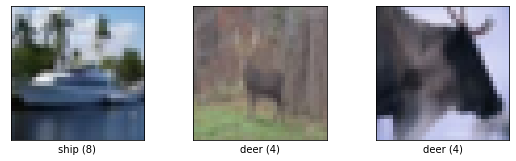

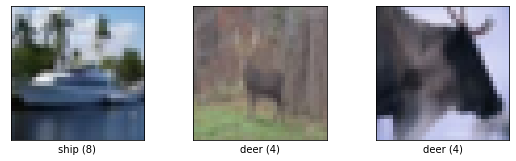

In [5]:
tfds.show_examples(ds["train"].take(3), ds_info = info)

In [6]:
input_shape = (224, 224, 3)
# input_shape = info.features["image"].shape
n_classes   = info.features["label"].num_classes
batch_size  = 1
epochs      = 10

In [7]:
def mapper(image, label):
    image = tf.image.resize(image, (input_shape[0], input_shape[1]))
    image = image / 255
    
    return image, label

In [8]:
gen_kwargs = dict(batch_size = batch_size, mapper = mapper)
train, val = list(map(lambda x: DatasetGenerator(x, **gen_kwargs),
                                                 split_dataset(ds["train"], splits = (0.7, 0.3))))
test = DatasetGenerator(ds["test"], **gen_kwargs)

#### Build Model

In [9]:
from tensorflow.keras.losses  import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy

from deeply.model.dam import DAM

In [10]:
dam = DAM(
    input_shape = input_shape,
    n_classes   = n_classes,
    batch_norm  = False
)

In [11]:
dam.compile(
    optimizer = "adam",
    loss      = SparseCategoricalCrossentropy(),
    metrics   = [SparseCategoricalAccuracy()]
#     loss      = "binary_crossentropy",
#     metrics   = "accuracy"
)

In [ ]:
steps_per_epoch  = len(train) // batch_size
validation_steps = len(val)   // batch_size

In [ ]:
norm = lambda x: x / (n_classes - 1)

def meta_mapper(X, y):
    X = norm(tf.argmax(X, axis = 1))
    y = norm(y)
    
    return X, y

In [ ]:
dam.fit(train, validation_data = val, verbose = 2, epochs = epochs,
        steps_per_epoch  = steps_per_epoch,
        validation_steps = validation_steps,
        meta_mapper      = meta_mapper,
        meta_epochs      = 50
)